# GHZ and W States
## Basado en el siguiente tutorial:
https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep8_Noise_and_Error_Mitigation.ipynb

In [1]:
from numpy import pi

In [2]:
# Importing standard Qiskit libraries

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import *
from qiskit_aer import AerSimulator

In [3]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [4]:
backend_simulator = AerSimulator()
backend_device = FakeBogotaV2()

In [5]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

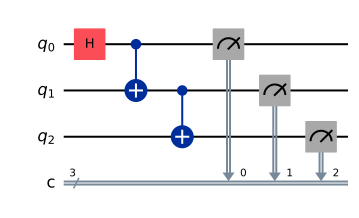

In [6]:
circuit.draw(output='mpl')

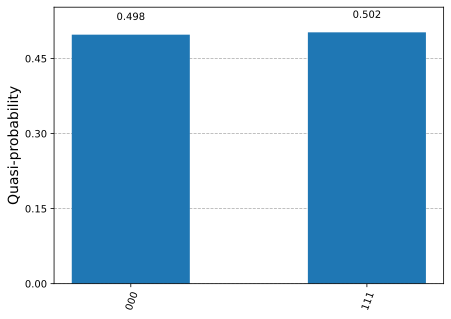

In [7]:
shots = 8192
sim_result = backend_simulator.run((circuit), shots=shots).result()
sim_counts = sim_result.get_counts(circuit)

plot_distribution(sim_counts)

In [8]:
transpiled_circuit = transpile(circuit, backend_device)

In [9]:
sampler2run = Sampler(mode=backend_device)

In [10]:
# Define the number of shots for the execution. 
shotno=1024

# Run the circuit on a real quantum computer. NB! This may take a while.
job = sampler2run.run([transpiled_circuit], shots= shotno)

# ID del Job para rastrear la ejecución del circuito en tiempo real.
print(f">>> Job ID: {job.job_id()}")

# Consulta del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job.status()}")

>>> Job ID: f5307ef2-2933-45e9-a308-d6a59429fcbc
>>> Job Status: JobStatus.RUNNING


In [11]:
device_result = job.result()

# Get results for the first (and only) PUB
pub_result = device_result[0]

# Get count measurement results
device_counts = pub_result.data.c.get_counts()

print(
    f"Counts for the 'meas' output register: {device_counts}"
)

Counts for the 'meas' output register: {'000': 468, '111': 426, '110': 27, '001': 25, '010': 11, '011': 21, '100': 24, '101': 22}


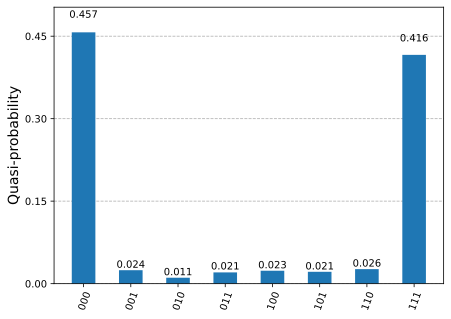

In [12]:
# Probabilidades de medición de cada salida, dada la ejecución real realizada.
plot_distribution(device_counts)

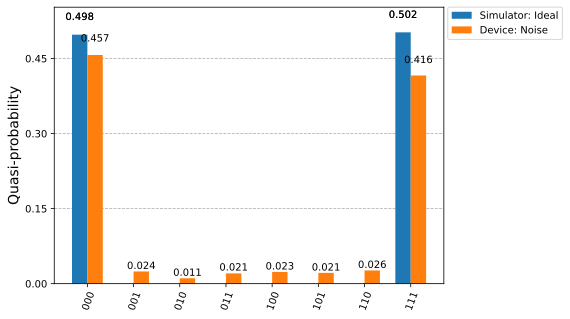

In [13]:
plot_distribution([sim_counts, device_counts], 
               legend=['Simulator: Ideal', 'Device: Noise'])

# Running error mitigation on a second circuit

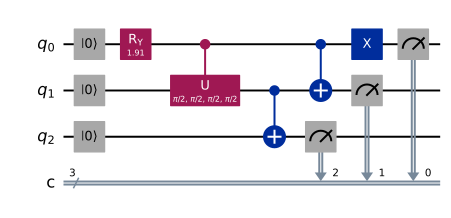

In [14]:
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit2 = QuantumCircuit(qreg_q, creg_c)

circuit2.reset(qreg_q[0])
circuit2.reset(qreg_q[1])
circuit2.reset(qreg_q[2])
circuit2.ry(1.9106332362490184, qreg_q[0])
circuit2.cu(pi / 2, pi / 2, pi / 2, pi / 2, qreg_q[0], qreg_q[1])
circuit2.cx(qreg_q[1], qreg_q[2])
circuit2.cx(qreg_q[0], qreg_q[1])
circuit2.x(qreg_q[0])
circuit2.measure(qreg_q[0], creg_c[0])
circuit2.measure(qreg_q[1], creg_c[1])
circuit2.measure(qreg_q[2], creg_c[2])

circuit2.draw(output='mpl')

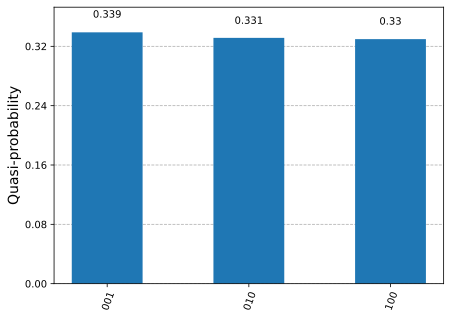

In [15]:
shots = 8192
sim_result2 = backend_simulator.run((circuit2), shots=shots).result()
sim_counts2 = sim_result2.get_counts(circuit2)

# Simulating the circuit and plotting the corresponding histogram:
plot_distribution(sim_counts2)

In [16]:
transpiled_circuit2 = transpile(circuit2, backend_device)
# transpiled_circuit.draw('mpl', style="iqp")
# plt.show()

In [17]:
# Define the number of shots for the execution. 
shotno=1024

# Run the circuit on a real quantum computer. NB! This may take a while.
job2 = sampler2run.run([transpiled_circuit2], shots= shotno)

# ID del Job para rastrear la ejecución del circuito en tiempo real.
print(f">>> Job ID: {job2.job_id()}")

# Consulta del estado de la ejecución del circuito cuántico
print(f">>> Job Status: {job2.status()}")

>>> Job ID: 3fd123c5-d302-497b-b5c3-220692df1f51
>>> Job Status: JobStatus.RUNNING


Counts for the 'meas' output register: {'010': 321, '100': 315, '001': 308, '110': 12, '101': 14, '000': 41, '011': 8, '111': 5}


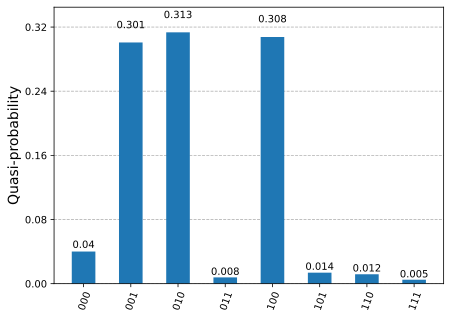

In [18]:
device_result2 = job2.result()

# Get results for the first (and only) PUB
pub_result2 = device_result2[0]

# Get count measurement results
device_counts2 = pub_result2.data.c.get_counts()

print(
    f"Counts for the 'meas' output register: {device_counts2}")

plot_distribution(device_counts2)

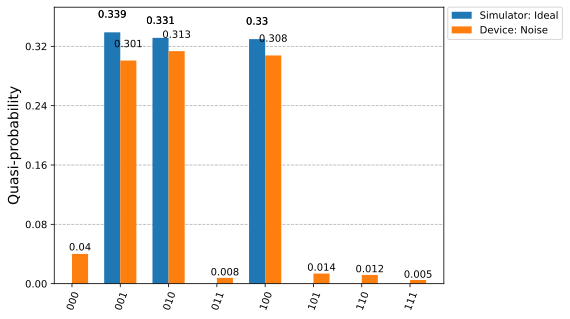

In [19]:
plot_distribution([sim_counts2, device_counts2], 
               legend=['Simulator: Ideal', 'Device: Noise'])

In [20]:
import mthree

In [21]:
mit = mthree.M3Mitigation(backend_device)

In [22]:
mit.cals_from_system(range(circuit2.num_qubits))

In [23]:
quasi = mit.apply_correction(device_counts2, range(circuit2.num_qubits))

In [24]:
probs = quasi.nearest_probability_distribution()

print(probs)

{'111': np.float32(0.002819046), '001': np.float32(0.32698333), '100': np.float32(0.33191755), '010': np.float32(0.3382801)}


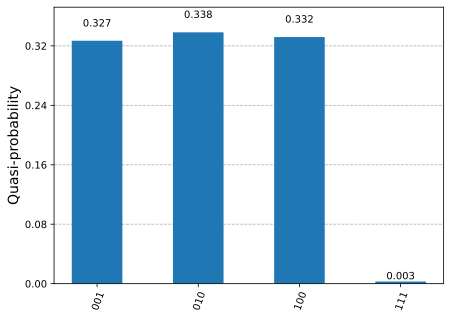

In [25]:
plot_distribution(probs)

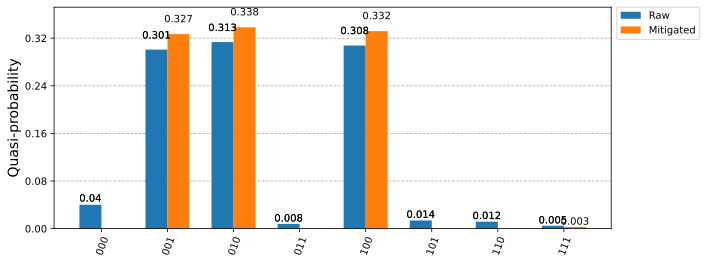

In [26]:
plot_distribution([device_counts2, probs], figsize=(10,4), legend=['Raw', 'Mitigated'])